# Tâche #2 : Classification d'incidents avec un réseau  récurrent et des *embeddings* Spacy

Cette tâche est similaire à la précédente et vous réutilisez les mêmes fichiers d’entraînement, de validation et de test. Cependant, vous devez utiliser des réseaux récurrents pour classifier les textes. Plus particulièrement, vous devez entraîner un réseau de neurones LSTM pour encoder les textes et une couche linéaire pour faire la classification des textes. 

Les consignes pour cette tâche sont: 
- 	Nom du notebook : rnn.ipynb
- 	Tokenisation : Utilisation de Spacy. 
- 	Plongements de mots : Ceux de Spacy. 
- 	Normalisation : Aucune normalisation. 
- 	Structure du réseau : Un réseau LSTM avec 1 seule couche pour l’encodage de textes. Je vous laisse déterminer la taille de cette couche (à expliquer). 
- 	Analyse : Comparer les résultats obtenus avec un réseau unidirectionnel et un réseau bidirectionnel. Si vous éprouvez des difficultés à entraîner les 2 réseaux dans un même notebook, faites une copie et nommez le 2e fichier rnn-bidirectionnel.ipynb.
- 	Expliquez comment les modèles sont utilisés pour faire la classification d’un texte. 
- 	Présentez clairement vos résultats et faites-en l’analyse. 


Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code. 
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc. 
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle. 

## 1. Création du jeu de données (*dataset*)

In [1]:
import spacy
import json
import numpy as np

spacy_model = spacy.load("en_core_web_md")
embedding_size = spacy_model.meta['vectors']['width']

# Assurez-vous que le modèle de langue de spacy est téléchargé
# python -m spacy download fr_core_news_md (par exemple pour le français)

# Charger le modèle de langue de spacy

# Définition des chemins vers les fichiers de données
train_data_path = './data/incidents_train.json'
dev_data_path = './data/incidents_dev.json'
test_data_path = './data/incidents_test.json'

def load_incident_dataset(filename):
    with open(filename, 'r') as fp:
        incident_list = json.load(fp)
        
        text = [item["text"] for item in incident_list]
        target = np.array([int(item["label"]) for item in incident_list])
         
    return text, target


# Créer les DataFrames pour chaque partition de données
train_list, train_target = load_incident_dataset(train_data_path)
dev_list, dev_target = load_incident_dataset(dev_data_path)
test_list, test_target = load_incident_dataset(test_data_path)

# Affichage de l'information de base sur les DataFrames
display(f"Train data: text_size {len(train_list)}, target_size {len(train_target)}")
display(f"Dev data: text_size {len(dev_list)}, target_size {len(dev_target)}")
display(f"Test data: text_size {len(test_list)}, target_size {len(test_target)}")


# Vérification des premiers enregistrements dans l'ensemble d'entraînement
train_list[0]


'Train data: text_size 2475, target_size 2475'

'Dev data: text_size 531, target_size 531'

'Test data: text_size 531, target_size 531'

' At approximately 8:50 a.m. on October 29  1997  Employee #1 was painting a  single story house at 2657 7th Ave  Sacramento  CA. He was caulking around the  peak of the roof line on the west side of the house  20 ft above the ground.  He was working off of a 24 ft aluminum extension ladder so that his feet were  approximately 12 to 13 feet above the ground. Employee #1 fell and suffered a  concussion and two dislocated discs in his lower back and was hospitalized.  The ladder was not secured to prevent movement.                                 '

In [2]:
import numpy as np

# Cette section sert à ajouter les tokens de paddings et ceux de mots inconnus dans le vocabulaire
# On crée également le dictionnaire qui lie les id vers les mots du vocabulaire
# Et enfin on crée le dictionnaire qui lie les id vers leurs embeddings (ou vecteur de plongement)

padding_token = "<PAD>"   # mot 0
unk_token = "<UNK>"    # mot 1
zero_vec_embedding = np.zeros(embedding_size, dtype=np.float64)

id2word = {}
id2word[0] = padding_token 
id2word[1] = unk_token 

word2id = {}
word2id[padding_token] = 0
word2id[unk_token] = 1

id2embedding = {}
id2embedding[0] = zero_vec_embedding
id2embedding[1] = zero_vec_embedding

## 2. Gestion de plongements de mots (*embeddings*)

In [4]:
from torch import FloatTensor

# Génère la matrice des plongements de chaque mot d'une séquence donnée
def get_spacy_embeddings(text, spacy_analyzer=spacy_model):
    doc = spacy_analyzer(text)
    embeddings = [token.vector for token in doc]
    return FloatTensor(embeddings)

In [5]:
# Remplissage des dictionnaires id vers mot et id vers embedding

word_index = 2
vocab = word2id.keys()
for question in train_list:
    for word in spacy_model(question):
        if word.text not in vocab:
            word2id[word.text] = word_index
            id2word[word_index] = word.text
            id2embedding[word_index] = word.vector
            word_index += 1

In [3]:
from torch.utils.data import Dataset, DataLoader
from torch import LongTensor
from typing import List
import numpy as np

class SpacyDataset(Dataset):
    def __init__(self, dataset: List[str] , target: np.array, wordId: dict, model=spacy_model):
        self.dataset = dataset
        self.doc_embeddings = [None for _ in range(len(dataset))]
        self.targets = target
        self.tokenizer = model
        self.word2id = wordId

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if self.doc_embeddings[index] is None:
            self.doc_embeddings[index] = self.tokenize(self.dataset[index])
        return LongTensor(self.doc_embeddings[index]), LongTensor([self.targets[index]]).squeeze(0)

    def tokenize(self, sentence):
        tokens = [word.text for word in self.tokenizer(sentence)]
        return [self.word2id.get(token, 1) for token in tokens]  # get(token, 1) retourne 1 par défaut si mot inconnu

In [6]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence

# Ajoute le padding dans toutes les séquences d'une batch
# On prend la phrase la plus longue du lot et on ajoute du padding à toutes les autres pour avoir des tailles similaires

def pad_batch(batch):
    x = [x for x,y in batch]
    x_true_length = [len(x) for x,y in batch]
    y = torch.stack([y for x,y in batch], dim=0)
    return ((pad_sequence(x, batch_first=True), x_true_length), y)

In [18]:
# On finalise la construction des 3 jeux de données et leurs dataloaders
train_dataset = SpacyDataset(train_list, train_target, word2id)
valid_dataset = SpacyDataset(dev_list, dev_target, word2id)
test_dataset = SpacyDataset(test_list, test_target, word2id)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True, collate_fn=pad_batch)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=pad_batch)

In [9]:
data = next(iter(train_dataloader))
print(data)


((tensor([[   2,  107,    8,  ...,    0,    0,    0],
        [   2,  107,  404,  ...,    0,    0,    0],
        [   2,    3,    4,  ...,    0,    0,    0],
        ...,
        [   2,  107,  202,  ...,   26, 8737, 3433],
        [   2,  107,    8,  ...,    0,    0,    0],
        [   2,    3,    4,  ...,    0,    0,    0]]), [108, 103, 99, 142, 119, 73, 58, 106, 189, 129, 173, 26, 87, 699, 34, 115]), tensor([5, 6, 0, 2, 0, 6, 6, 5, 0, 5, 6, 0, 3, 8, 8, 5]))


## 3. Création de modèle(s)

In [10]:
# Creation d'un embedding layer qui sera utilisé dans le modele principal

vocab_size = len(id2embedding)
embedding_layer = np.zeros((vocab_size, embedding_size), dtype=np.float32)

for token_id, embedding in id2embedding.items():
    embedding_layer[token_id,:] = embedding

embedding_layer = torch.from_numpy(embedding_layer)

print("Taille de la couche d'embeddings:", embedding_layer.shape)

Taille de la couche d'embeddings: torch.Size([11642, 300])


In [14]:
import torch.nn as nn
import torch.nn.functional as F

# Modèle rnn avec une couche de plongements, une couche de LSTM et une tête de prédiction en sortie

class LSTMClassifier(nn.Module):
    def __init__(self, embeddings, hidden_state_size, nb_classes, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings)
        self.rnn = nn.LSTM(input_size=embeddings.size()[1], hidden_size=hidden_state_size, batch_first=True, bidirectional=bidirectional)
        multiplier = 2 if bidirectional else 1
        self.classification_layer = nn.Linear(hidden_state_size * multiplier, nb_classes)

    def forward(self, x, x_lenght):
        x = self.embedding_layer(x)
        packed_batch = pack_padded_sequence(x, x_lenght, batch_first=True, enforce_sorted=False)
        packed_output, (hidden_state, cell_state) = self.rnn(packed_batch)

        if self.rnn.bidirectional:
            # Concatenating the hidden states of the last time step from both directions
            x = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1)
        else:
            x = hidden_state[-1,:,:]  # Taking the last time step of the hidden state

        x = self.classification_layer(x)
        return x


#### Modele unidirectionnel

In [12]:
from poutyne import set_seeds

set_seeds(42)
hidden_size = 100
nb_classes = 9

# Modele unidirectionnel
model = LSTMClassifier(embedding_layer, hidden_size, nb_classes)

/Users/mac/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Modele bidirectionnel

In [13]:

bidirectional_model = LSTMClassifier(embedding_layer, hidden_size, nb_classes, bidirectional=True)

## 4. Fonctions utilitaires

Vous pouvez mettre ici toutes les fonctions qui seront utiles pour les sections suivantes.

In [21]:
from IPython.display import Image

def display_plots(experiment):
# Specify the path to your PNG image file
    directory = f"{experiment.directory}/plots"

    acc = f"{directory}/acc.png"
    f1 = f"{directory}/fscore_macro.png"
    loss = f"{directory}/loss.png"

    # Display the PNG image
    display(Image(filename=acc), Image(filename=f1), Image(filename=loss))

## 5. Entraînement de modèle(s)

### Entrainement unidirectionel

In [15]:
from poutyne.framework import Experiment
from poutyne import set_seeds

set_seeds(42)
hidden_size = 100
optimizer = "ADAM"

directory_name = 'model_task2/unidirectional'

experiment = Experiment(directory_name,
                        model,
                        optimizer = optimizer,
                        task="classification",
                        loss_function="cross_entropy",
                        )

In [16]:
logging = experiment.train(train_dataloader, valid_dataloader, epochs=50, disable_tensorboard=True)

Epoch:  1/50 Train steps: 155 Val steps: 34 1m41.28s loss: 1.689554 acc: 41.212121 fscore_macro: 0.112351 val_loss: 1.539203 val_acc: 47.080979 val_fscore_macro: 0.165909
Epoch 1: val_acc improved from -inf to 47.08098, saving file to model_task2/unidirectional/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 155 Val steps: 34 43.16s loss: 1.398877 acc: 50.303030 fscore_macro: 0.205536 val_loss: 1.276159 val_acc: 55.367232 val_fscore_macro: 0.267201
Epoch 2: val_acc improved from 47.08098 to 55.36723, saving file to model_task2/unidirectional/checkpoint_epoch_2.ckpt
Epoch:  3/50 Train steps: 155 Val steps: 34 43.80s loss: 1.080686 acc: 62.060606 fscore_macro: 0.346109 val_loss: 1.099136 val_acc: 61.016949 val_fscore_macro: 0.316350
Epoch 3: val_acc improved from 55.36723 to 61.01695, saving file to model_task2/unidirectional/checkpoint_epoch_3.ckpt
Epoch:  4/50 Train steps: 155 Val steps: 34 42.97s loss: 0.887520 acc: 68.929293 fscore_macro: 0.444239 val_loss: 1.105251 val_acc: 63.465

KeyboardInterrupt: 

### Entrainement bidirectionel

In [24]:
directory_name = "model_task2/bidirectional"

bidirectional_experiment = Experiment(directory_name,
                        bidirectional_model,
                        optimizer = optimizer,
                        task="classification",
                        loss_function="cross_entropy",
                        )

In [25]:
logging = bidirectional_experiment.train(train_dataloader, valid_dataloader, epochs=50, disable_tensorboard=True)

Epoch:  1/50 Train steps: 155 Val steps: 34 2m34.10s loss: 1.667398 acc: 41.454545 fscore_macro: 0.120226 val_loss: 1.502962 val_acc: 48.399247 val_fscore_macro: 0.174397
Epoch 1: val_acc improved from -inf to 48.39925, saving file to model_task2/bidirectional/checkpoint_epoch_1.ckpt
Epoch:  2/50 Train steps: 155 Val steps: 34 1m31.27s loss: 1.292779 acc: 56.282828 fscore_macro: 0.254074 val_loss: 1.192141 val_acc: 58.568738 val_fscore_macro: 0.302051
Epoch 2: val_acc improved from 48.39925 to 58.56874, saving file to model_task2/bidirectional/checkpoint_epoch_2.ckpt
Epoch:  3/50 Step:  14/155   9.03% |█▊                  |ETA: 1m20.35s loss: 0.862999 acc: 75.000000

KeyboardInterrupt: 

## 6. Évaluation et analyse de résultats

### Evaluation unidirectionnelle

Found best checkpoint at epoch: 5
lr: 0.001, loss: 0.731929, acc: 74.5051, fscore_macro: 0.543774, val_loss: 1.10672, val_acc: 65.9134, val_fscore_macro: 0.423284
Loading checkpoint model_task2/unidirectional/checkpoint_epoch_5.ckpt
Running test
Test steps: 531 2.29s test_loss: 1.133736 test_acc: 60.451977 test_fscore_macro: 0.408028      


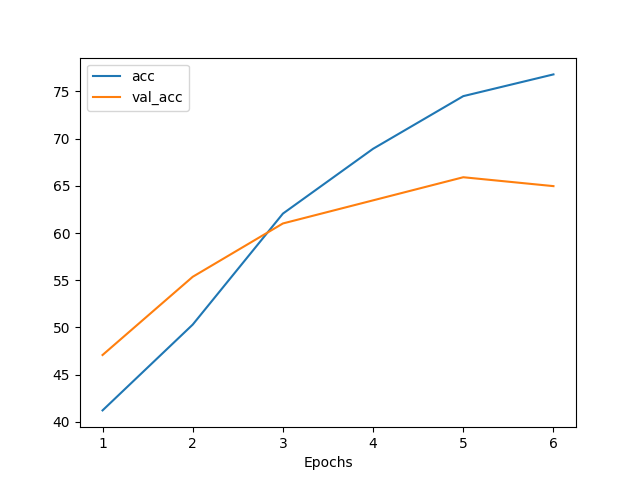

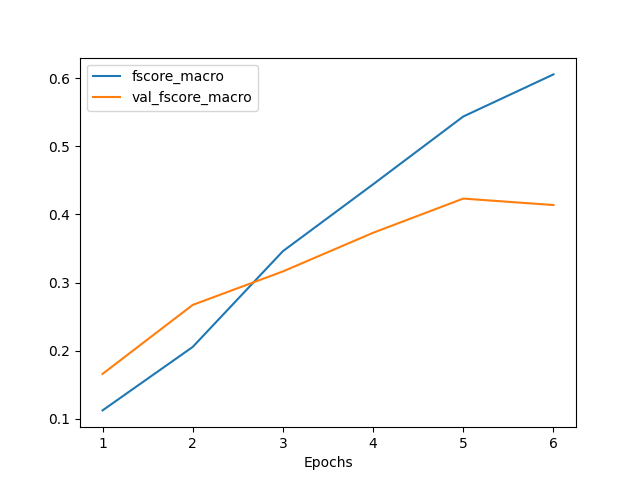

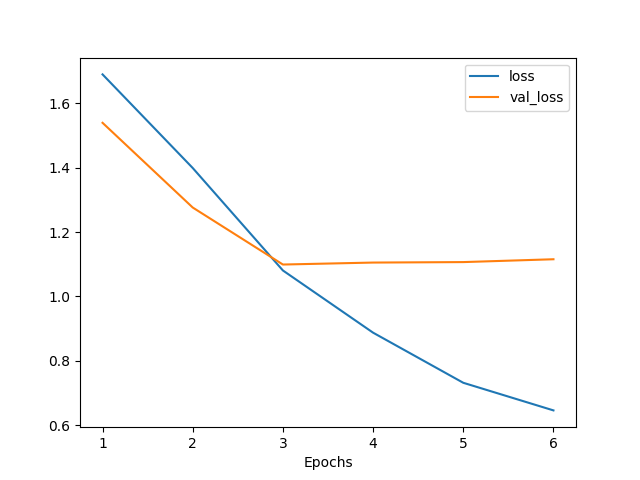

In [22]:
experiment.test(test_dataloader)
display_plots(experiment)

### Evaluation bidirectionnelle

Found best checkpoint at epoch: 2
lr: 0.001, loss: 1.29278, acc: 56.2828, fscore_macro: 0.254074, val_loss: 1.19214, val_acc: 58.5687, val_fscore_macro: 0.302051
Loading checkpoint model_task2/bidirectional/checkpoint_epoch_2.ckpt
Running test
Step:   1/531   0.19% |                    |ETA: 3.33s test_loss: 0.276483 test_acc: 100.000000

Test steps: 531 4.53s test_loss: 1.191679 test_acc: 58.754864 test_fscore_macro: 0.327209      


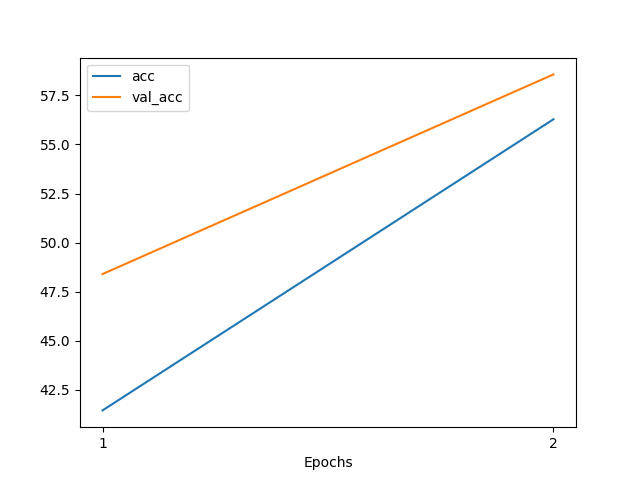

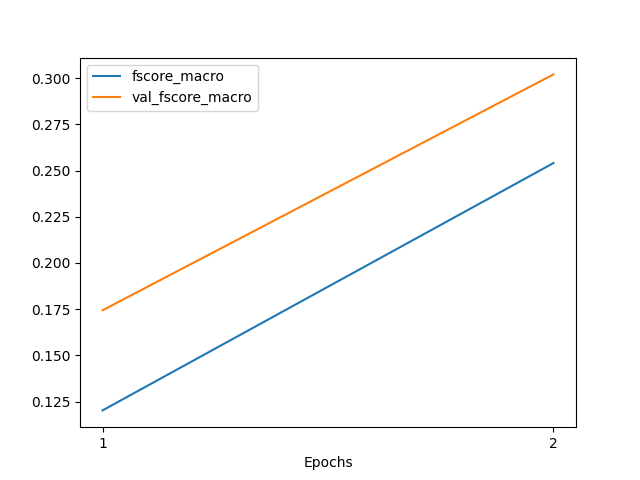

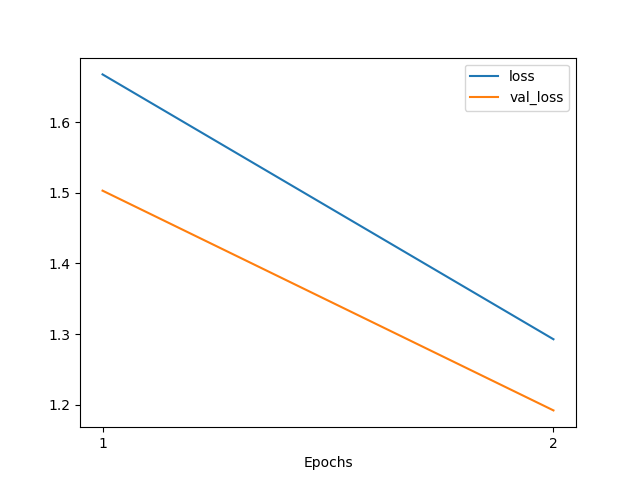

In [26]:
bidirectional_experiment.test(test_dataloader)
display_plots(bidirectional_experiment)
